# Blind source separation with HypGMCA
### or how to impose sparsity on both the spectra and the sources

In [5]:
# Useful packages

import sys
sys.path.insert(1,'/Users/jbobin/Documents/Python/LENA_DEVL/Toolbox/BSS/pyGMCALab')
from  pyGMCA.common import utils as bu
from  pyGMCA.bss.gmca import gmca
from  pyGMCA.bss.hypgmca import hypgmca
from pyGMCA.common.wavelets import pyStarlet as pys
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as pyf

%matplotlib inline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}
plt.rcParams["figure.figsize"] = (20,10)
plt.rc('font', **font)


## Load simulated data

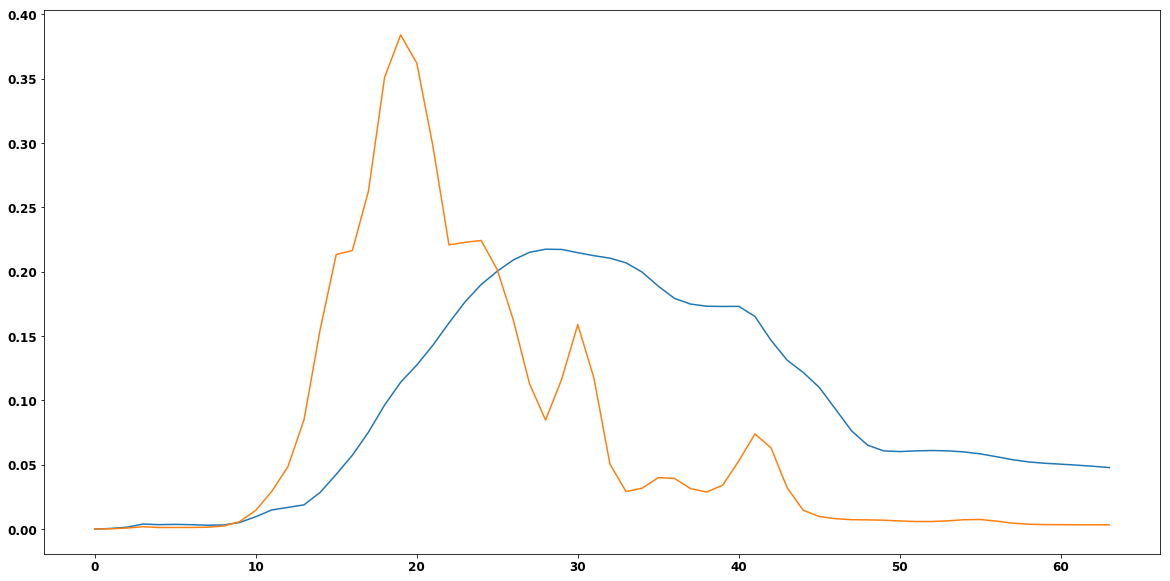

In [6]:
S0 = pyf.getdata("./data/Sources.fits").reshape((4,128*128))
S0 = np.dot(np.diag(1./np.linalg.norm(S0,axis=1)),S0)
A0 = pyf.getdata("./data/Spectra.fits")
A0 = A0[0:64,[0,1]]
Xin = np.dot(A0,S0[[0,1],:])

plt.plot(A0)


## Apply a 2D-1D starlet transform

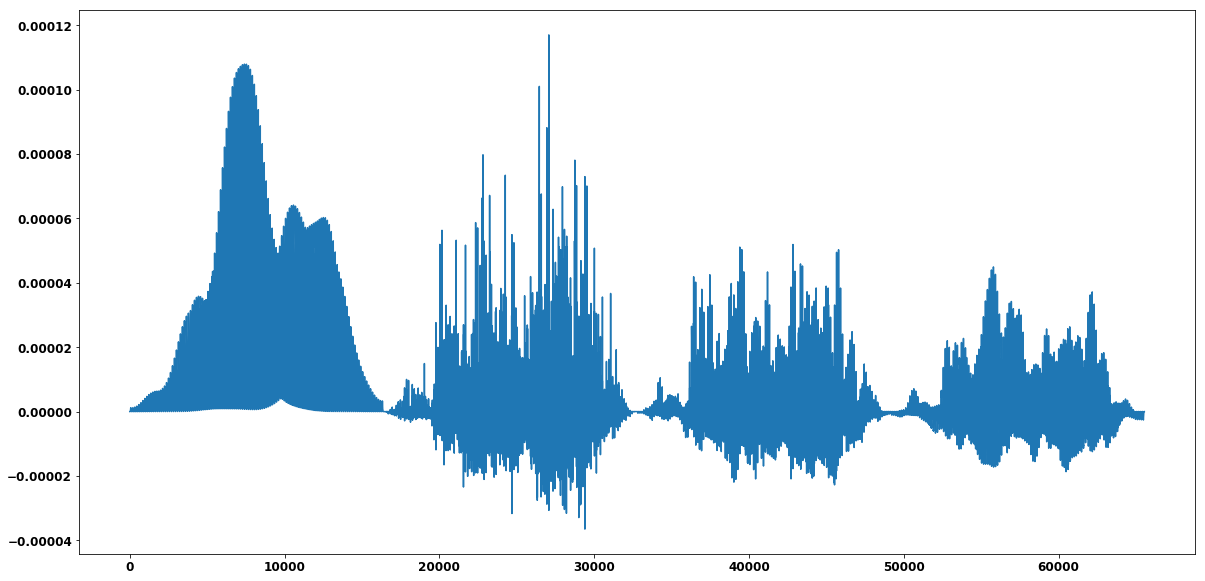

In [7]:
# Number of 2D scales
J_2D = 3
J_1D = 3
m = np.shape(A0)[0]
N = 128

mw = pys.forward(Xin.reshape((m,N,N)),J=J_2D)
X = mw[:,:,:,J_2D].reshape(m,N**2)
for j in range(J_2D):
    X = np.hstack([X,mw[:,:,:,j].reshape(m,N**2)])

mw = pys.forward1d(X.T,J=J_1D)
X = np.transpose(mw[:,:,J_1D].reshape(-1,m))
for j in range(J_1D):
    X = np.vstack([X,np.transpose(mw[:,:,j].reshape(-1,m))])
    
plt.plot(X[0,:])

In [8]:
# Indices for 2D coarse-scale
I_CS_2D = np.linspace(N**2,np.shape(X)[1]-1,np.shape(X)[1]-N**2,dtype='int32')

# Indices for 1D coarse-scale
I_CS_1D = np.linspace(m,np.shape(X)[0]-1,np.shape(X)[0]-m,dtype='int32')

In [13]:
# Number of sources:

n = 2

Rh = hypgmca.HypGMCA(X,n=n,mints=0,nmax=250,L0=0,UseP=2,Index_1D=I_CS_1D,Index_2D=I_CS_2D)


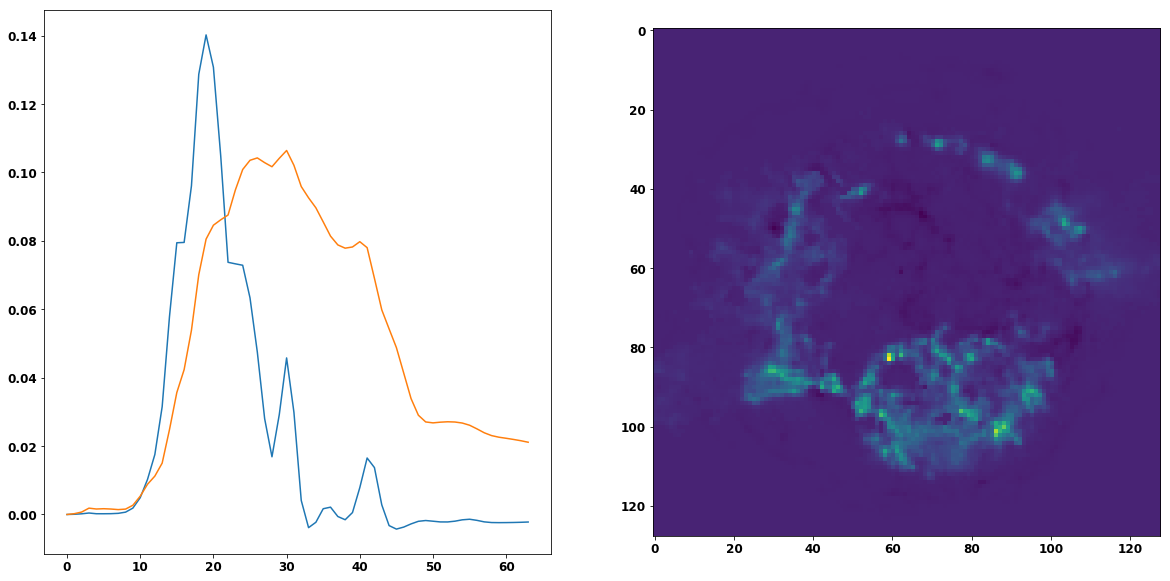

In [16]:
# Reconstructed:

Se = np.real(Rh['sources'])

Srec = 0.*S0[0:2,:]
for j in range(J_2D+1):
    Srec += Se[:,j*N**2:(j+1)*N**2]
    
piS = np.dot(Srec.T,np.linalg.inv(np.dot(Srec,Srec.T)))
Arec = np.dot(Xin,piS)
    
plt.subplot(121)
plt.plot(Arec)
plt.subplot(122)
plt.imshow(Srec[0,:].reshape(128,128))